# Тестовое задание

На основе данных из файла `Training.xlsb` с целевой функцией `Marker` необходимо:
1. Проанализировать данные в файле
2. Построить гипотезы
3. Обучить логистическую регрессию
4. Снять метрики качества

## 1. Анализ данных

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from tqdm import notebook
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

Откроем файл:

In [2]:
df = pd.read_excel('Training.xlsb', engine = 'pyxlsb')
pd.set_option('display.max_columns', None)
df.head()

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


Проанализируем полученные данные. Перед нами данные с информацией о клиентах. При этом отсутствуют названия столбцов, кроме `ID` - индивидуальный номер клиента, и `MARKER` - целевая функция. Наиболее вероятно, что перед нами стоит задача банковского скоринга.

Из-за отсутствия названий столбцов, произведем анализ по имеющимся данным. Интерпретировать числа, а также столбцы с вариантами `YES/NO` не представляется возможным, поэтому проанализируем столбцы с более информативными данными: `I`, `K`, `M`, `N`, `O`, `P`, `Q`, `S`. Для этого выведем списки с уникальными значениями данных для каждого из них:

In [3]:
for value in df[['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'S']]:
    print(value, ':', df[value].unique())
    print('---------------------------------------------------')

I : ['Woman' 'Man']
---------------------------------------------------
K : ['Mogilev region' 'Minsk region' 'Vitebsk region' 'Brest region' 'Minsk'
 'Grodno region' 'Gomel region']
---------------------------------------------------
M : ['NE employee' 'Pensioner' 'Head/Deputy head (organiz.)'
 'Head/Deputy head (division)' 'Enterpreneur']
---------------------------------------------------
N : ['Secondary education (plus special education)'
 'Higher education (one or more)' 'Incomplete higher education'
 'Primary or lower secondary education']
---------------------------------------------------
O : ['Married' 'Divorced/widow' 'Single/unmarried' 'Cohabitation']
---------------------------------------------------
P : ['2 Two' '1 One' '0 Zero' '3 Three' 'More than 3']
---------------------------------------------------
Q : ['property' 'otherwise' 'rent/hire']
---------------------------------------------------
S : ['Works' 'No couple' 'Pensioner' 'Unemployed' 'Student']
-----------------

Можем сделать следующие выводы:
1. Столбец `I` содержит информацию, вероятнее всего, о поле клиента
2. Столбец `K` содержит информацию, вероятнее всего, о регионе, из которого клиент
3. Столбец `M` содержит информацию, вероятнее всего, о трудовой занятости клиента
4. Столбец `N` содержит информацию, вероятнее всего, об образовании клиента
5. Столбец `O` содержит информацию, вероятнее всего, о семейном положении клиента
6. Столбец `P` содержит информацию, вероятнее всего, о количестве детей клиента
7. Столбец `Q` содержит информацию, вероятнее всего, о варианте проживания клиента
8. Столбец `S` содержит информацию, вероятнее всего, о трудовой занятости второй половины клиента

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89734 entries, 0 to 89733
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      89734 non-null  int64  
 1   A       89734 non-null  float64
 2   B       89734 non-null  float64
 3   C       89734 non-null  float64
 4   D       89734 non-null  float64
 5   E       89734 non-null  float64
 6   F       89734 non-null  float64
 7   G       89734 non-null  int64  
 8   H       89734 non-null  float64
 9   I       89734 non-null  object 
 10  J       89734 non-null  float64
 11  K       89734 non-null  object 
 12  L       89734 non-null  int64  
 13  M       89734 non-null  object 
 14  N       89734 non-null  object 
 15  O       89734 non-null  object 
 16  P       89734 non-null  object 
 17  Q       89734 non-null  object 
 18  R       89734 non-null  object 
 19  S       89734 non-null  object 
 20  T       89734 non-null  object 
 21  U       89734 non-null  object 
 22

Предварительно оценим датасет:
1. Состоит из 89734 строк и 26 столбцов
2. Пропуски в данных отсутствуют
3. Для числовых данных применяются типы данных `int` и `float`, для текстовых - `str`, т.е. типы данных соответствуют значениям

Сделаем проверку на дубликаты:

In [5]:
df.duplicated().sum()

0

Дубликаты отсутствуют.
Таким образом, датасет не имеет пропусков и дубликатов, типы данных соответствуют значениям.

Определим, какие значения являются категориальными, какие - числовыми:

In [6]:
for value in df.columns.to_list():
    print('-------------------')
    print(value)
    print('Количество уникальных значений:', len(df[value].unique()))

-------------------
ID
Количество уникальных значений: 89734
-------------------
A
Количество уникальных значений: 46408
-------------------
B
Количество уникальных значений: 56381
-------------------
C
Количество уникальных значений: 11051
-------------------
D
Количество уникальных значений: 14941
-------------------
E
Количество уникальных значений: 49962
-------------------
F
Количество уникальных значений: 59471
-------------------
G
Количество уникальных значений: 11
-------------------
H
Количество уникальных значений: 13
-------------------
I
Количество уникальных значений: 2
-------------------
J
Количество уникальных значений: 528
-------------------
K
Количество уникальных значений: 7
-------------------
L
Количество уникальных значений: 511
-------------------
M
Количество уникальных значений: 5
-------------------
N
Количество уникальных значений: 4
-------------------
O
Количество уникальных значений: 4
-------------------
P
Количество уникальных значений: 5
-------------

Количество уникальных значений в столбцах от `A` до `F` такого же порядка, что и общее количество значений, можем сделать вывод, что эти значения - числовые. Количество уникальных значений в столбцах `G`, `H`, `I`, `K` и от `M` до `MARKER` - от 2 до 13, можем сделать вывод, что эти значения - категориальные. 

Столбец `ID` - порядковые номера клиентов. Смысловой нагрузки при обучении модели нести не будут, при обучении удалим этот столбец.

Столбцы `J` и `L` имеют около 520 уникальных значений, что более, чем в 170 раз меньше, чем общее количество строк датасета. При этом `L` типа `int`, что свидетельствует с большей вероятностью о градации значений, т.е. о категориальном типе. Выведем по 50 уникальных значений каждого:

In [7]:
print(df.J.unique()[:50])
print('------------------')
print(df.L.unique()[:50])

[33.75       33.25       38.58333333 61.25       48.58333333 38.91666667
 47.41666667 25.91666667 63.25       61.66666667 25.75       39.83333333
 49.66666667 30.25       40.5        29.91666667 27.41666667 55.08333333
 56.08333333 46.41666667 30.58333333 24.41666667 31.5        43.75
 26.66666667 52.33333333 59.16666667 23.91666667 35.33333333 40.83333333
 56.91666667 46.58333333 30.16666667 53.58333333 29.66666667 32.66666667
 29.58333333 61.16666667 41.41666667 46.83333333 23.33333333 22.66666667
 29.33333333 43.08333333 30.91666667 25.66666667 33.83333333 22.25
 22.58333333 23.83333333]
------------------
[132   6  71  48  44  38  24 421  18   9   3  42  37 144  15  36  12  60
  25 408 108  86 324  79 240 110  45  13  96  84   5   4  98  89  30  26
 180  10 192  72 124 120 216 204  55  27 193 245 150  28]


Тип значений столбца `J` - `float`. Однако можно заметить, что большинство значений имеют дробную часть такую, какую можно получить при делении на число, кратное 3. То есть, вероятно этот столбец также был типа `int` перед тем, как все его значения разделили на число, кратное 3. 

Таким образом, столбцы `L` и `J` категориального типа.

Создадим 2 списка: `numeric_columns` - для столбцов числового типа, `categorial_columns` - категориального (`MARKER` включать не будем, так как в последствии будем его использовать как целевую функцию):

In [8]:
numeric_columns = ['A', 'B', 'C', 'D', 'E', 'F']
categorial_columns = ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']

Проверим влияние численных признаков на целевую функцию (MARKER). Построим матрицу корреляций:

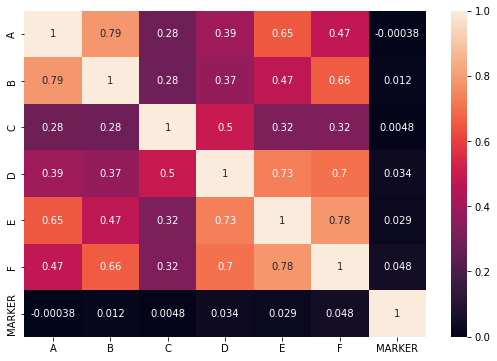

In [9]:
plt.figure(figsize = (9, 6))
sns.heatmap((df[numeric_columns + ['MARKER']]).corr(), annot = True);

Можем сделать вывод о том, что численные признаки на целевую функцию не влияют. Однако можно заметить сильную корреляцию между самими признаками. Это необходимо учитывать при создании модели.

## 2. Построение гипотез

Матрица корреляций показала, что целевая функция не зависит от признаков численного типа. Проверим, как влияют категориальные признаки. Построим матрицу корреляций для числовых данных категориального типа и проверим, какая зависимость между ними и целевой функцией:  

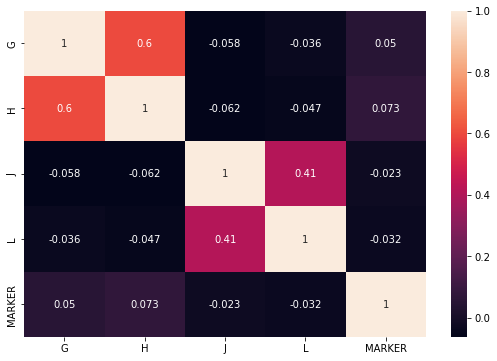

In [10]:
plt.figure(figsize = (9, 6))
sns.heatmap((df[categorial_columns + ['MARKER']]).corr(), annot = True);

Числовые признаки категориального типа также на целевую функцию не влияют, однако довольно сильно коррелируют между собой.

In [11]:
df_categ_temp = pd.get_dummies(df[['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'MARKER']])

for value in df_categ_temp.columns:
    corr_cat = df_categ_temp[value].corr(df_categ_temp['MARKER'])
    if abs(corr_cat) >= 0.1:
        print(corr_cat, value)

1.0 MARKER


Корреляции между признаками и целевой функцией не наблюдается.

Проведем оценку, насколько отличаются клиенты, получившие и не получившие заем. Для этого создадим 2 дополнительных датасета: `df_temp_ones` - содержащий клиентов, заём для которых был одобрен банком, `df_temp_zeros` - содержащих клиентов, которым было отказано:

In [12]:
df_temp_ones = df[df['MARKER'] == 1][categorial_columns]
df_temp_zeros = df[df['MARKER'] == 0][categorial_columns]

Создадим функцию, возвращающую датасет, содержащий: название столбцов, значения, наиболее часто встречающиеся в соответствующих столбцах, а также долю этих значений отсительно всех в процентах:

In [13]:
def analys(dataframe, target = 'none'):
    
    # создание 3 списков, содержащих: temp_list_name - названия столбцов, 
    # temp_most_common - наиболее часто встречающиеся значения, temp_list_interest - доля значений в %
    temp_list_interest = []
    temp_list_name = []
    temp_most_common = []
    
    # перебор в цикле назвений столбцов датафрейма
    for value in dataframe.columns.to_list():
        # определение количества уникальных значений для каждого столбца и занесение в список
        temp_cat_list = dataframe[value].value_counts().to_list() 
        # сортировка списка по убыванию
        temp_cat_list.sort(reverse = True)
        # занесение в temp_list_name названия столбца
        temp_list_name.append(value)
        # занесение в temp_most_common наиболее часто встречающееся значение
        temp_most_common.append(pd.DataFrame(dataframe[value].
                                             value_counts()).sort_values(by = value, ascending = False).T.columns[0])
        # занесение в temp_list_interest доли значения относительно всех в %
        temp_list_interest.append(round(temp_cat_list[0] / dataframe.shape[0], 4) * 100)

    # создание датасета по 3 спискам и переименование названий столбцов
    temp_df = pd.DataFrame(data = [temp_list_name, temp_most_common, temp_list_interest]).T
    temp_df = temp_df.rename(columns = {
        0 : 'name column',
        1 : target + ' most common value',
        2 : target + ' interest, %'
    })
    
    # возврат датасета, отсортированного по убыванию по столбцу с долей значения в %
    return temp_df.sort_values(by = target + ' interest, %', ascending = False).reset_index(drop = True)

Применим данную функцию к датасетам `df_temp_ones` и `df_temp_zeros`, объединим таблицы по столбцу `name column`:

In [14]:
df_analys = analys(df_temp_ones, 'ones').merge(analys(df_temp_zeros, 'zeros'), on = 'name column', how = 'left')
df_analys

,name column,ones most common value,"ones interest, %",zeros most common value,"zeros interest, %"
0,R,No,93.86,No,82.82
1,Q,property,86.26,property,90.79
2,N,Secondary education (plus special education),86.26,Secondary education (plus special education),64.96
3,M,NE employee,85.38,NE employee,80.75
4,V,No,85.09,No,87.45
5,T,Yes,82.46,Yes,83.98
6,U,Yes,78.65,Yes,85.33
7,W,No,74.56,No,57.41
8,X,No,72.22,No,61.36
9,G,13,69.59,5,27.85


В большинстве столбцов наиболее часто встречающееся значения для 1 и 0 одинаковые, поэтому выведем столбцы, где значения разные:

In [15]:
df_analys[df_analys['ones most common value'] != df_analys['zeros most common value']]

,name column,ones most common value,"ones interest, %",zeros most common value,"zeros interest, %"
9,G,13,69.59,5,27.85
10,I,Man,53.8,Woman,54.63
11,S,No couple,52.34,Works,52.91
14,H,1.99,34.5,0.0,70.77
16,L,12,9.65,36,6.62
17,J,32.083333,1.46,33.916667,0.39


Сделаем следующие выводы:
1. Доля значений в столбцах `L` и `J` - менее 10%, поэтому столбцы для нас неинформативны
2. В столбце `I` может быть 2 значения - `Man` и `Woman`, при этом одобрения и отказы в каждом датасете примерно равны для обеих групп, столбец также неинформативен
3. В столбце `G` может быть 11 значения, при этом процент одобрений заёма для клиентов категории `13` - примерно 70%, и отказов для категории `5` - примерно 28%
4. В столбце `S` может быть 5 значений, при этом процент одобрений заёма для клиентов категории `No couple` - примерно 52%, и отказов для категории `Works` - примерно 53%
5. В столбце `H` может быть 13 значений, при этом процент одобрений заёма для клиентов категории `1.99` - примерно 35%, и отказов для категории `0` - примерно 71%

Таким образом, наиболее интересными для нас столбцами являются `G`, `S` и `H`. Проведем анализ одобрений и отказов клиентов наиболее часто встречающихся категорий в этих столбцах относительно всех клиентов:

In [16]:
print('Доля отобрений заёмов клиентов категории "13" столбца "G"\n    и категории "No couple" столбца "S" относительно всех одобрений, %:', round(len(df[df['G'] == 13].query('MARKER == 1 & S == "No couple"')) / len(df[df['MARKER'] == 1]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отобрений заёмов клиентов категории "13" столбца "G"\n    и категории "1.99" столбца "H" относительно всех одобрений, %:', round(len(df[df['G'] == 13].query('MARKER == 1 & H == 1.99')) / len(df[df['MARKER'] == 1]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отобрений заёмов клиентов категории "1.99" столбца "H"\n    и категории "No couple" столбца "S" относительно всех одобрений, %:', round(len(df[df['H'] == 1.99].query('MARKER == 1 & S == "No couple"')) / len(df[df['MARKER'] == 1]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отобрений заёмов клиентов категории "13" столбца "G",\n    категории "No couple" столбца "S" и категории "1.99" столбца "H" относительно всех одобрений, %:', round(len(df[df['G'] == 13].query('MARKER == 1 & S == "No couple" & H == 1.99')) / len(df[df['MARKER'] == 1]) * 100, 2))

Доля отобрений заёмов клиентов категории "13" столбца "G"
    и категории "No couple" столбца "S" относительно всех одобрений, %: 35.09
----------------------------------------------------------------------------
Доля отобрений заёмов клиентов категории "13" столбца "G"
    и категории "1.99" столбца "H" относительно всех одобрений, %: 33.33
----------------------------------------------------------------------------
Доля отобрений заёмов клиентов категории "1.99" столбца "H"
    и категории "No couple" столбца "S" относительно всех одобрений, %: 17.84
----------------------------------------------------------------------------
Доля отобрений заёмов клиентов категории "13" столбца "G",
    категории "No couple" столбца "S" и категории "1.99" столбца "H" относительно всех одобрений, %: 16.96


In [17]:
print('Доля отказов в заёмах клиентов категории "5" столбца "G"\n    и категории "Works" столбца "S" относительно всех отказов, %:', round(len(df[df['G'] == 5].query('MARKER == 0 & S == "Works"')) / len(df[df['MARKER'] == 0]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отказов в заёмах клиентов категории "5" столбца "G"\n    и категории "0" столбца "H" относительно всех отказов, %:', round(len(df[df['G'] == 5].query('MARKER == 0 & H == 0')) / len(df[df['MARKER'] == 0]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отказов в заёмах клиентов категории "0" столбца "H"\n    и категории "Works" столбца "S" относительно всех отказов, %:', round(len(df[df['H'] == 0].query('MARKER == 0 & S == "Works"')) / len(df[df['MARKER'] == 0]) * 100, 2))
print('----------------------------------------------------------------------------')
print('Доля отказов в заёмах клиентов категории "5" столбца "G",\n    категории "Works" столбца "S" и категории "0" столбца "H" относительно всех отказов, %:', round(len(df[df['G'] == 5].query('MARKER == 0 & S == "Works" & H == 0')) / len(df[df['MARKER'] == 0]) * 100, 2))

Доля отказов в заёмах клиентов категории "5" столбца "G"
    и категории "Works" столбца "S" относительно всех отказов, %: 14.9
----------------------------------------------------------------------------
Доля отказов в заёмах клиентов категории "5" столбца "G"
    и категории "0" столбца "H" относительно всех отказов, %: 27.85
----------------------------------------------------------------------------
Доля отказов в заёмах клиентов категории "0" столбца "H"
    и категории "Works" столбца "S" относительно всех отказов, %: 37.69
----------------------------------------------------------------------------
Доля отказов в заёмах клиентов категории "5" столбца "G",
    категории "Works" столбца "S" и категории "0" столбца "H" относительно всех отказов, %: 14.9


Таким образом, сформулируем 2 гипотезы:
1. Наиболее вероятно одобрение заёма клиентам, которые соответствуют категории `13` в столбце `G` (или и) категории `Works` столбца `S`
2. Наиболее вероятен отказ в заёме клиентам, которые соответствуют категории `0` в столбце `H` (или и) категории `Works` столбца `S`

## 3. Обучение модели

### 3.1 Подготовка признаков

Перед обучение модели необходимо подготовить признаки. 

Так как по условию задания необходимо обучить модель на основе логистической регрессии, для кодировки категориальных признаков текстового типа применим технику One Hot Encoding. Для этого выделим из общего датасета категориальные признаки и разделим новый на текстовые и числовые типы:

In [18]:
df_categorial = df.copy() 
df_categorial_text = df_categorial[categorial_columns].drop(['G', 'H', 'J', 'L'], axis = 1) 
df_categorial_numeric_G = df_categorial.G
df_categorial_numeric_H = df_categorial.H
df_categorial_numeric_J = df_categorial.J
df_categorial_numeric_L = df_categorial.L

Создадим функцию, кодирующую числовые категориальные признаки. Чтобы столбцы случайно не могли совпадать по названию, функция также будет переименовывать столбцы в зависимости от датасета:

In [19]:
def encoding_rename(dataframe, col = 'none'):
    
    dataframe = pd.get_dummies(dataframe, drop_first = True)
    for value in dataframe.columns.to_list():
        dataframe = dataframe.rename(columns = {value : str(value) + '_' + col})
        
    return dataframe   

Закодируем датасеты с категориальными признаками и объединим их в один:

In [20]:
df_categorial_update = pd.concat([encoding_rename(df_categorial_numeric_G, col = 'G'), 
                                  encoding_rename(df_categorial_numeric_H, col = 'H'),
                                  encoding_rename(df_categorial_numeric_J, col = 'J'), 
                                  encoding_rename(df_categorial_numeric_L, col = 'L'),
                                  pd.get_dummies(df_categorial_text)], axis = 1)

Объединим признаки в один датасет:

In [21]:
df_numeric = df.copy() 
df_numerical = df_categorial[numeric_columns]
df_update = pd.concat([df_numerical, df_categorial_update], axis = 1)

Разделим весь датасет на признаки - `features` и целевую функцию - `target`:

In [22]:
target = df.MARKER
features = df_update

Разделим `features` и `target` на обучающую выборку - `train`, валидационную - `valid` и тестовую - `test` в соотношении `3:1:1`:

In [23]:
random_state = 12345

features_train, features_valid, target_train, target_valid = train_test_split(
                                features, target, test_size = 0.2, random_state = random_state, stratify = target)

features_train, features_test, target_train, target_test = train_test_split(
                                features_train, target_train, test_size = 0.25, random_state = random_state, 
                                                                                            stratify = target_train)

Подготовим численные признаки - приведем их к одному масштабу:

In [24]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])
pd.options.mode.chained_assignment = None

features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

features_train = features_train.reset_index(drop = True)
features_valid = features_valid.reset_index(drop = True)
features_test = features_test.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
target_valid = target_valid.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)

Проанализируем размер обучающей выборки:

In [25]:
features_train.head()

,A,B,C,D,E,F,3_G,4_G,5_G,6_G,9_G,10_G,11_G,13_G,20_G,24_G,0.01_H,1.1_H,1.17_H,1.235_H,1.32_H,1.99_H,2.49_H,2.5_H,2.99_H,3.0_H,3.49_H,3.5_H,21.083333333333332_J,21.166666666666668_J,21.25_J,21.333333333333332_J,21.416666666666668_J,21.5_J,21.583333333333332_J,21.666666666666668_J,21.75_J,21.833333333333332_J,21.916666666666668_J,22.0_J,22.083333333333332_J,22.166666666666668_J,22.25_J,22.333333333333332_J,22.416666666666668_J,22.5_J,22.583333333333332_J,22.666666666666668_J,22.75_J,22.833333333333332_J,22.916666666666668_J,23.0_J,23.083333333333332_J,23.166666666666668_J,23.25_J,23.333333333333332_J,23.416666666666668_J,23.5_J,23.583333333333332_J,23.666666666666668_J,23.75_J,23.833333333333332_J,23.916666666666668_J,24.0_J,24.083333333333332_J,24.166666666666668_J,24.25_J,24.333333333333332_J,24.416666666666668_J,24.5_J,24.583333333333332_J,24.666666666666668_J,24.75_J,24.833333333333332_J,24.916666666666668_J,25.0_J,25.083333333333332_J,25.166666666666668_J,25.25_J,25.333333333333332_J,25.416666666666668_J,25.5_J,25.583333333333332_J,25.666666666666668_J,25.75_J,25.833333333333332_J,25.916666666666668_J,26.0_J,26.083333333333332_J,26.166666666666668_J,26.25_J,26.333333333333332_J,26.416666666666668_J,26.5_J,26.583333333333332_J,26.666666666666668_J,26.75_J,26.833333333333332_J,26.916666666666668_J,27.0_J,27.083333333333332_J,27.166666666666668_J,27.25_J,27.333333333333332_J,27.416666666666668_J,27.5_J,27.583333333333332_J,27.666666666666668_J,27.75_J,27.833333333333332_J,27.916666666666668_J,28.0_J,28.083333333333332_J,28.166666666666668_J,28.25_J,28.333333333333332_J,28.416666666666668_J,28.5_J,28.583333333333332_J,28.666666666666668_J,28.75_J,28.833333333333332_J,28.916666666666668_J,29.0_J,29.083333333333332_J,29.166666666666668_J,29.25_J,29.333333333333332_J,29.416666666666668_J,29.5_J,29.583333333333332_J,29.666666666666668_J,29.75_J,29.833333333333332_J,29.916666666666668_J,30.0_J,30.083333333333332_J,30.166666666666668_J,30.25_J,30.333333333333332_J,30.416666666666668_J,30.5_J,30.583333333333332_J,30.666666666666668_J,30.75_J,30.833333333333332_J,30.916666666666668_J,31.0_J,31.083333333333332_J,31.166666666666668_J,31.25_J,31.333333333333332_J,31.416666666666668_J,31.5_J,31.583333333333332_J,31.666666666666668_J,31.75_J,31.833333333333332_J,31.916666666666668_J,32.0_J,32.083333333333336_J,32.166666666666664_J,32.25_J,32.333333333333336_J,32.416666666666664_J,32.5_J,32.583333333333336_J,32.666666666666664_J,32.75_J,32.833333333333336_J,32.916666666666664_J,33.0_J,33.083333333333336_J,33.166666666666664_J,33.25_J,33.333333333333336_J,33.416666666666664_J,33.5_J,33.583333333333336_J,33.666666666666664_J,33.75_J,33.833333333333336_J,33.916666666666664_J,34.0_J,34.083333333333336_J,34.166666666666664_J,34.25_J,34.333333333333336_J,34.416666666666664_J,34.5_J,34.583333333333336_J,34.666666666666664_J,34.75_J,34.833333333333336_J,34.916666666666664_J,35.0_J,35.083333333333336_J,35.166666666666664_J,35.25_J,35.333333333333336_J,35.416666666666664_J,35.5_J,35.583333333333336_J,35.666666666666664_J,35.75_J,35.833333333333336_J,35.916666666666664_J,36.0_J,36.083333333333336_J,36.166666666666664_J,36.25_J,36.333333333333336_J,36.416666666666664_J,36.5_J,36.583333333333336_J,36.666666666666664_J,36.75_J,36.833333333333336_J,36.916666666666664_J,37.0_J,37.083333333333336_J,37.166666666666664_J,37.25_J,37.333333333333336_J,37.416666666666664_J,37.5_J,37.583333333333336_J,37.666666666666664_J,37.75_J,37.833333333333336_J,37.916666666666664_J,38.0_J,38.083333333333336_J,38.166666666666664_J,38.25_J,38.333333333333336_J,38.416666666666664_J,38.5_J,38.583333333333336_J,38.666666666666664_J,38.75_J,38.833333333333336_J,38.916666666666664_J,39.0_J,39.083333333333336_J,39.166666666666664_J,39.25_J,39.333333333333336_J,39.416666666666664_J,39.5_J,39.583333333333336_J,39.666666666666664_J,39.75_J,39.833333333333336_J,39.916666666666664_J,40.0_J,40.083333333333336_J,40.166666666666664_J,40.25_J,40.333333333333336_J,40.416666666666664_J,40.5_J,

In [26]:
features_train.shape

(53840, 1113)

Количество столбцов обучающей выборки составляет более 1100. Вероятно, при обучении модели необходимо уменьшить количество столбцов, чтобы избежать переобучения модели. Напишем функцию, которая возвращает обучающую, валидационную и тестовую выборки с уменьшенным количеством столбцов, а также долю дисперсии от начальной:

In [27]:
def reduction_col(features_train, features_valid, features_test, n_comp = 10):
    
    pca = PCA(n_components = n_comp)

    features_train_reduced = pca.fit_transform(features_train)
    features_valid_reduced = pca.transform(features_valid)
    features_test_reduced = pca.transform(features_test)

    return features_train_reduced, features_valid_reduced, features_test_reduced, pca.explained_variance_ratio_.cumsum()[-1]

Также создадим функцию, отражающую график доли дисперсии в зависимости от количества оставшихся столбцов, а также, используя ее, построим график. Максимально возможную потерю определим как 10%.

In [28]:
def reduction_col_graph(n_beg, n_end = 50, step = -100, variance_end = 0.9):

    list_variance = []
    for index in notebook.tqdm(range(features_train.shape[1], n_end, step)):
        list_variance.append(reduction_col(features_train, features_valid, features_test, n_comp = index)[3])

    plt.figure(figsize = (12, 8));
    plt.plot([0, n_beg], [variance_end, variance_end], 'bo--');
    plt.plot(range(n_beg, n_end, step), list_variance);

  0%|          | 0/11 [00:00<?, ?it/s]

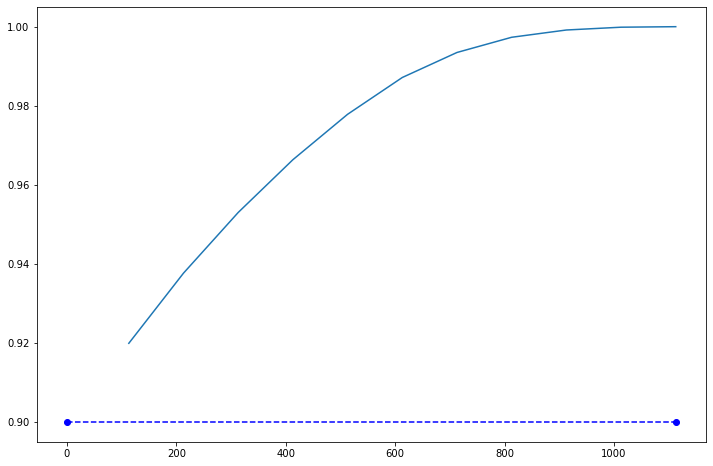

In [29]:
reduction_col_graph(n_beg = features_train.shape[1], n_end = 50, step = -100, variance_end = 0.9)

Из графика следует, что, сокращая количество столбцов примерно в 10 раз, потеря дисперсии составляет примерно 8%.

### 3.2 Анализ целевой функции и выбор основной метрики

Проанализируем, какую метрику будем использовать для модели. 

Основная задача данной модели - минимизировать ложно-положительную ошибку (FP). Для этой задачи могла бы в качестве основной подойти метрика `precision`. Однако нет уверенности, что метрика даст высокий результат, если классы несбалансированы, скорее наоборот, ее значение будет очень низкое. Поэтому в первую очередь определим отношение количества единиц к общему количеству значений: 

In [30]:
target[target == 1].count() / target.count()

0.0038112644036819936

Отношение составляет менее 0.4%, то есть на фоне общего количества нулей, модель будет не замечать единицы. В таком случае мы можем предположить следующее:
1. Либо мы не учитываем дисбаланс, и модель обнуляет все единицы. Хотя значение FP в данном случае и будет минимально, TP также будет около нуля. То есть модель определяет, что нельзя выдавать заем даже надежным клиентам, у которых `target = 1`
2. Либо мы учитываем дисбаланс, и модель совершает большую долю ошибок FP, что создает огромные риски в выдаче заема ненадежным клиентам для банка

И в одном, и в другом случае метрика `precision`, которая является отношением TP / (TP + FP), будет околонулевая: либо TP = 0, либо сумма TP + FP будет много больше, чем TP. Таким образом, метрику `precision` нельзя использовать как основную. На замену ей можно взять метрику `accuracy` для каждого класса.

Таким образом, сформулируем основные метрики - `accuracy` для каждого класса и минимизация `FP`.

Создадим функции, которая будет принимать значения целевой функции и предсказаний, а возвращать значения `accuracy` и матрицы со значениями TN, FP, FN, TP: 

In [31]:
def accuracy_0(target, predictions):
    
    cf_matrix = confusion_matrix(target, predictions)
    TN, FP, FN, TP = cf_matrix.ravel()
    
    return TN / (TN + FP)

In [32]:
def accuracy_1(target, predictions):
    
    cf_matrix = confusion_matrix(target, predictions)
    TN, FP, FN, TP = cf_matrix.ravel()
    
    return TP / (TP + FN)

Для визуализции матрицы со значениями TN, FP, FN, TP также создадим функцию `cf_matrix`:

In [33]:
def cf_matrix_graph(cf_matrix):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues');

### 3.3 Обучение модели LR

Создадим функцию, обучающую модель логистической регрессии, а также визуализирующую качество модели по метрикам `accuracy_0`, `accuracy_1` и количеству `FP` в зависимости от значений `C` и учета баланса классов:

In [34]:
def log_regression_class(features_train, target_train, features_valid, target_valid, class_weight = None):
    
    warnings.filterwarnings('ignore')
    
    acc_0 = []
    acc_1 = []
    fp = []
    tn = []
    list_C = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 
              1e+1, 5e+1, 1e+2, 5e+2, 1e+3, 5e+3, 1e+4, 5e+4, 1e+5, 5e+5, 1e+6, 5e+6]
    
    for value in list_C:
            
        model = LogisticRegression(random_state = random_state, solver = 'liblinear', 
                                                max_iter = 1000, class_weight = class_weight,
                                                verbose = 0, n_jobs = -1, C = value)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        cf_matrix_result = confusion_matrix(target_valid, predictions)
        TN, FP, FN, TP = cf_matrix_result.ravel()

        acc_0.append(accuracy_0(target_valid, predictions))
        acc_1.append(accuracy_1(target_valid, predictions))
        fp.append(FP)
        tn.append(TN)
        
    plt.figure(figsize = (12, 10))
    plt.subplot(211)
    plt.plot(acc_0, label = 'accuracy_0');
    plt.plot(acc_1, label = 'accuracy_1');
    plt.legend(loc = 'upper left')
    plt.title('Accuracy')

    plt.subplot(212)
    plt.plot(tn, label = 'tn');
    plt.plot(fp, label = 'fp');
    plt.legend(loc = 'upper left')
    plt.title('Ones')

Применим функцию `log_regression_class`, при этом в настройках модели не будем учитывать дисбаланс классов:

Wall time: 36 s


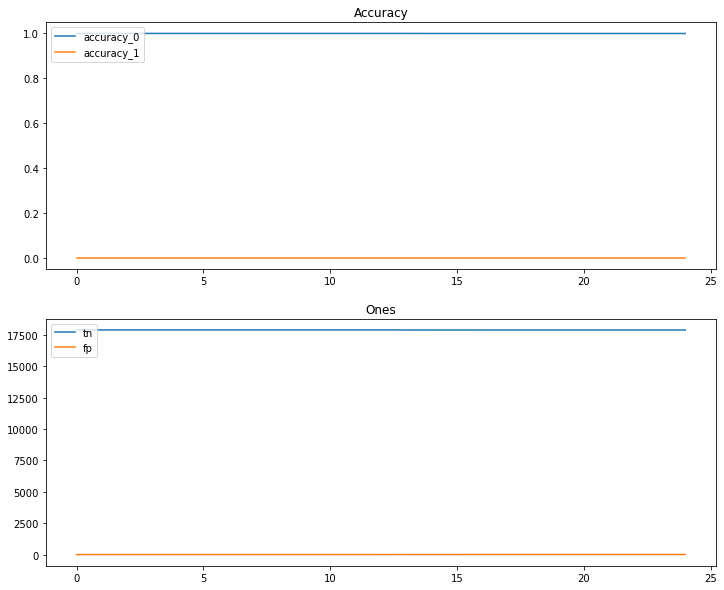

In [35]:
%%time
log_regression_class(features_train, target_train, features_valid, target_valid, class_weight = None)

Применим функцию `log_regression_class` с учетом дисбаланса классов:

Wall time: 1min 21s


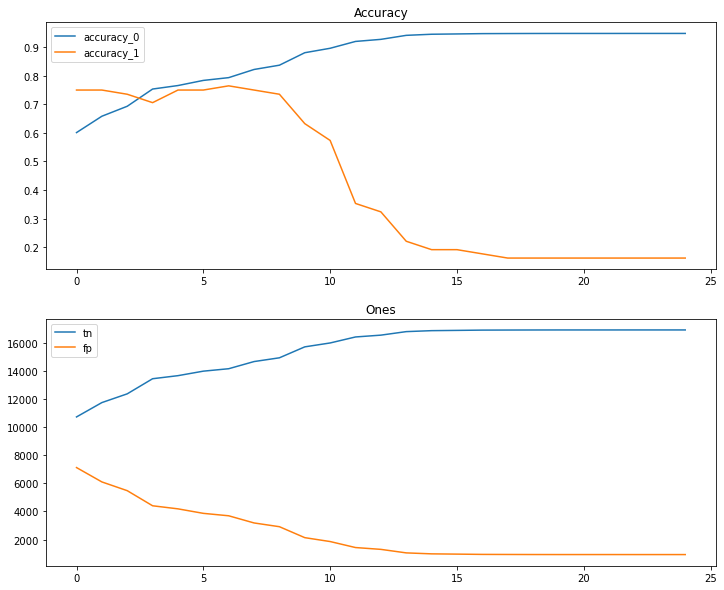

In [36]:
%%time
log_regression_class(features_train, target_train, features_valid, target_valid, class_weight = 'balanced')

Как и предполагалось, модель, учитывающая дисбаланс классов, дает гораздо лучший результат.

Проверим, влияет ли на качество модели уменьшение количества столбцов. Применим функцию `reduction_col` для обучающей и валидационной выборок и проверим, как меняется качество модели.

Уменьшим количество столбцов до 100 и применим функцию `reduction_col`:

Wall time: 1min 24s


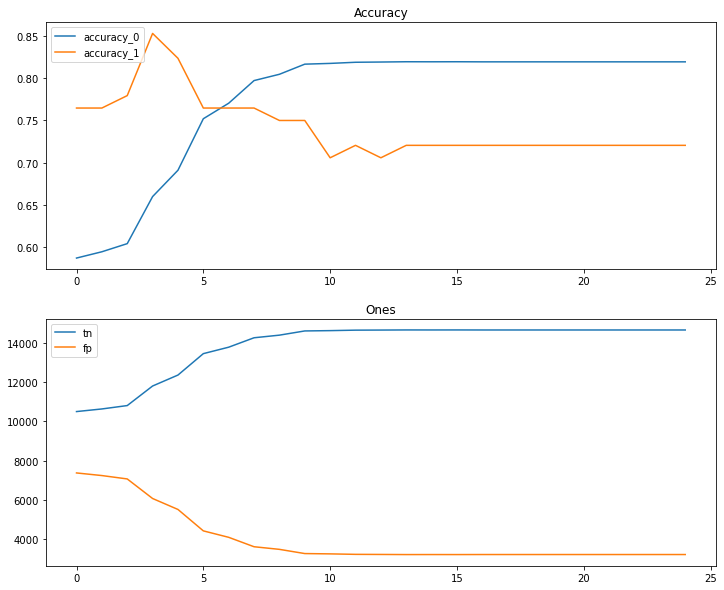

In [37]:
%%time
reduc_col_100 = reduction_col(features_train, features_valid, features_test, n_comp = 100)
log_regression_class(reduc_col_100[0], target_train, reduc_col_100[1], target_valid, class_weight = 'balanced')

Уменьшим количество столбцов до 50 и применим функцию `reduction_col`:

Wall time: 16.7 s


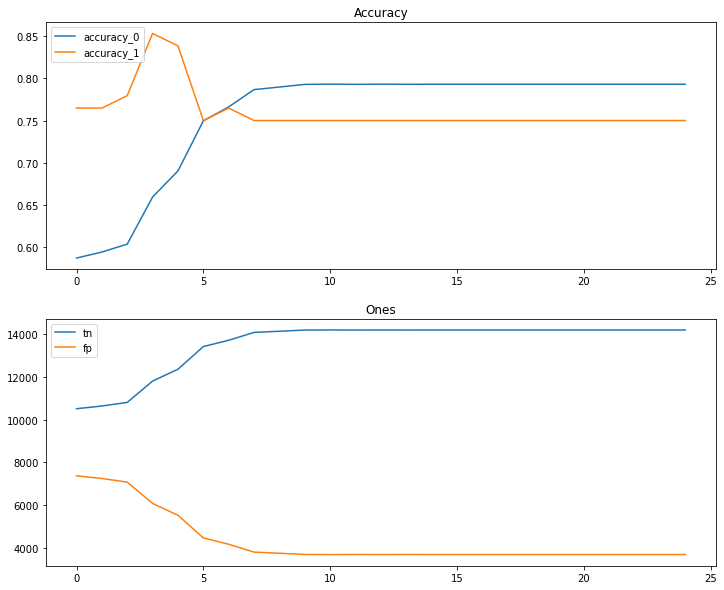

In [38]:
%%time
reduc_col_50 = reduction_col(features_train, features_valid, features_test, n_comp = 50)
log_regression_class(reduc_col_50[0], target_train, reduc_col_50[1], target_valid, class_weight = 'balanced')

Уменьшим количество столбцов до 30 и применим функцию `reduction_col`:

Wall time: 10.3 s


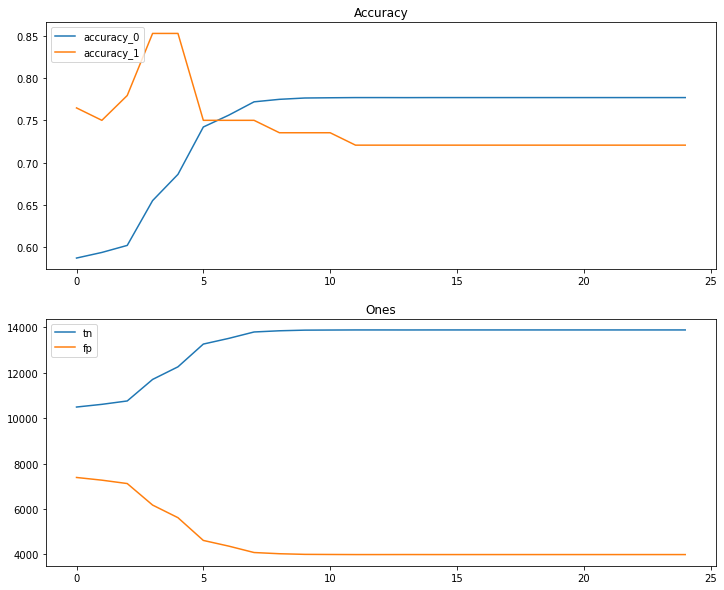

In [39]:
%%time
reduc_col_30 = reduction_col(features_train, features_valid, features_test, n_comp = 30)
log_regression_class(reduc_col_30[0], target_train, reduc_col_30[1], target_valid, class_weight = 'balanced')

Уменьшим количество столбцов до 20 и применим функцию `reduction_col`:

Wall time: 7.48 s


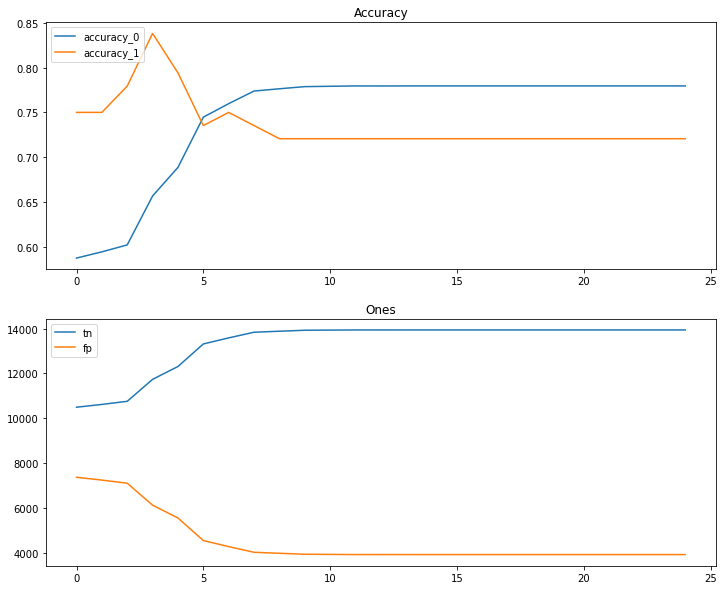

In [40]:
%%time
reduc_col_20 = reduction_col(features_train, features_valid, features_test, n_comp = 20)
log_regression_class(reduc_col_20[0], target_train, reduc_col_20[1], target_valid, class_weight = 'balanced')

Из предложенных наиболее удачным вариантом модели является та, которая обучена на выборке, состоящей из 50 столбцов. По сравнению с моделью, обученной на данных без уменьшения выборки, можем заметить:
1. Уменьшение значения метрики `accuracy_0`
2. Увеличение значения метрики `accuracy_1`
3. Увеличение количества `FP`

Однако сравним модель, обученную на начальных данных, с моделью, обученной на данных, сокращенных до 50 столбцов: хотя метрика `accuracy_0` снизилась примерно на 16% и количество `FP` возросло примерно в 2 раза, однако метрика `accuracy_1` возрасла примерно на 85%. То есть модель вышла на баланс между метриками `accuracy_0` и `accuracy_1`.

Попробуем еще один метод настройки модели. Воспользуемся `SelectKBest` и отберем наиболее важные столбцы. Создадим функцию, возвращающую датасет и N наиболее важных столбцов:

In [41]:
def featureSelect_dataframe(features, target, criteria, n_columns):
    
    reg = SelectKBest(criteria, k = n_columns).fit(features, target)
    features_upd = reg.transform(features)
    features = features[[val for index, val in enumerate(features.columns) if reg.get_support()[index]]]

    return features

In [42]:
def important_columns(features_train, target_train, features_valid, features_test, n_columns):
    
    new_features_train = featureSelect_dataframe(features_train, target_train, criteria = f_classif, n_columns = n_columns)
    new_features_valid = features_valid[new_features_train.columns.to_list()]
    new_features_test = features_test[new_features_train.columns.to_list()]
    
    return new_features_train, new_features_valid, new_features_test

Обучим модель на тех же количествах столбцов, что и предыдущий алгоритм:

Wall time: 32.2 s


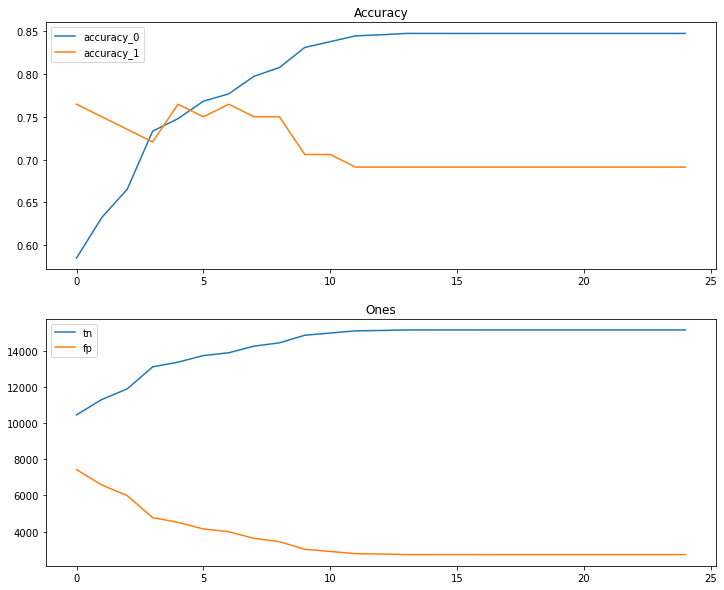

In [43]:
%%time
imp_col_100 = important_columns(features_train, target_train, features_valid, features_test, 100)
log_regression_class(imp_col_100[0], target_train, imp_col_100[1], target_valid, class_weight = 'balanced')

Wall time: 14 s


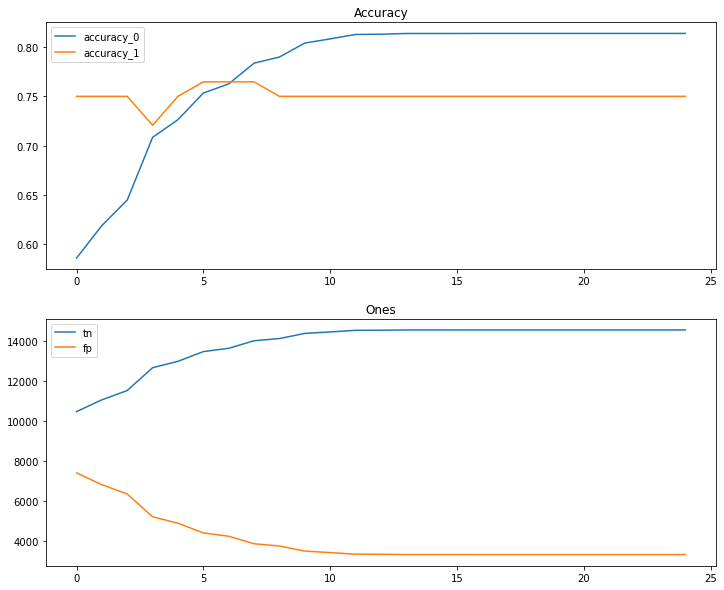

In [44]:
%%time
imp_col_50 = important_columns(features_train, target_train, features_valid, features_test, 50)
log_regression_class(imp_col_50[0], target_train, imp_col_50[1], target_valid, class_weight = 'balanced')

Wall time: 10.2 s


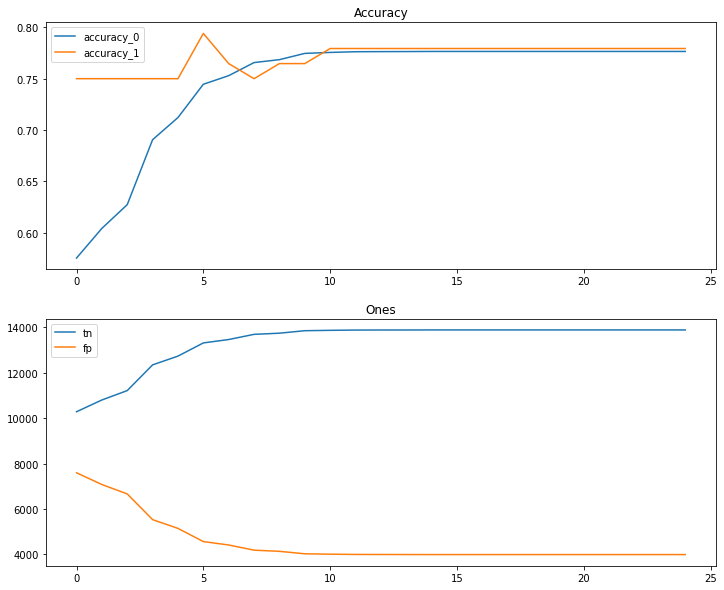

In [45]:
%%time
imp_col_30 = important_columns(features_train, target_train, features_valid, features_test, 30)
log_regression_class(imp_col_30[0], target_train, imp_col_30[1], target_valid, class_weight = 'balanced')

Wall time: 7.19 s


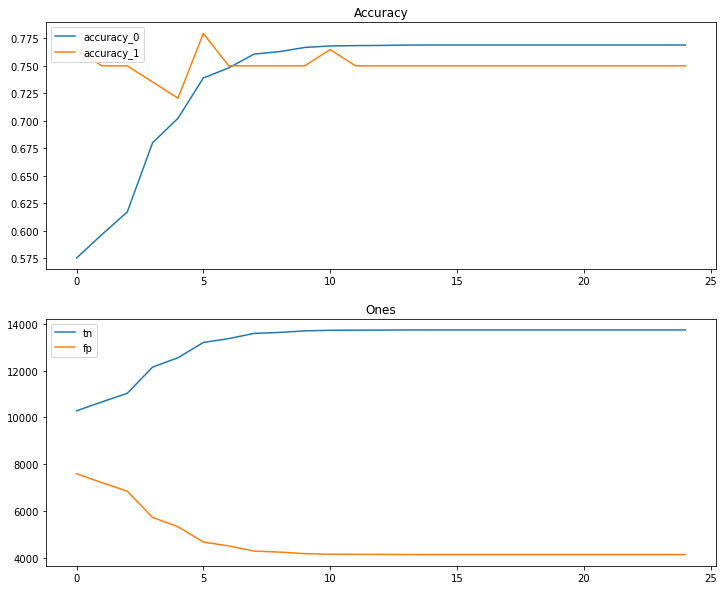

In [46]:
%%time
imp_col_20 = important_columns(features_train, target_train, features_valid, features_test, 20)
log_regression_class(imp_col_20[0], target_train, imp_col_20[1], target_valid, class_weight = 'balanced')

Как и на прошлом алгоритме, наиболее удачная модель - обученная на 50 самых важных столбцах.

Сравним 3 модели: 
1. С учетом дисбаланса классов
2. С учетом дисбаланса классов + сокращение количества столбцов
3. С учетом дисбаланса классов + отбор наиболее важных столбцов

Получим метрики качества первой модели:

Accuracy 0:  0.8220258403713854
Accuracy 1:  0.75
Precision:  0.015774822146613052
Recall:  0.75
F1:  0.030899727355346865
Accuracy:  0.8217529392098958
ROC-AUC:  0.7860129201856927


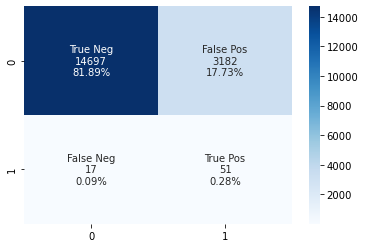

In [47]:
warnings.filterwarnings('ignore')
model_1 = LogisticRegression(random_state = random_state, solver = 'liblinear', 
                                                max_iter = 1000, class_weight = 'balanced',
                                                verbose = 0, n_jobs = -1, C = 5e-3)
model_1.fit(features_train, target_train)
predictions_1 = model_1.predict(features_valid)
cf_matrix_result_1 = confusion_matrix(target_valid, predictions_1)
cf_matrix_graph(cf_matrix_result_1)

print('Accuracy 0: ', accuracy_0(target_valid, predictions_1))
print('Accuracy 1: ', accuracy_1(target_valid, predictions_1))
print('Precision: ', precision_score(target_valid, predictions_1))
print('Recall: ', recall_score(target_valid, predictions_1))
print('F1: ', f1_score(target_valid, predictions_1))
print('Accuracy: ', accuracy_score(target_valid, predictions_1))
print('ROC-AUC: ', roc_auc_score(target_valid, predictions_1))

Получим метрики качества второй модели:

Accuracy 0:  0.792885508138039
Accuracy 1:  0.75
Precision:  0.013585508790623336
Recall:  0.75
F1:  0.026687598116169546
Accuracy:  0.7927230177745584
ROC-AUC:  0.7714427540690195


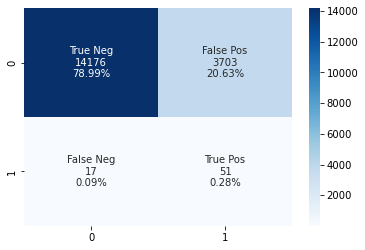

In [48]:
warnings.filterwarnings('ignore')
model_2 = LogisticRegression(random_state = random_state, solver = 'liblinear', 
                                                max_iter = 1000, class_weight = 'balanced',
                                                verbose = 0, n_jobs = -1, C = 1e+5)
model_2.fit(reduc_col_50[0], target_train)
predictions_2 = model_2.predict(reduc_col_50[1])
cf_matrix_result_2 = confusion_matrix(target_valid, predictions_2)
cf_matrix_graph(cf_matrix_result_2)

print('Accuracy 0: ', accuracy_0(target_valid, predictions_2))
print('Accuracy 1: ', accuracy_1(target_valid, predictions_2))
print('Precision: ', precision_score(target_valid, predictions_2))
print('Recall: ', recall_score(target_valid, predictions_2))
print('F1: ', f1_score(target_valid, predictions_2))
print('Accuracy: ', accuracy_score(target_valid, predictions_2))
print('ROC-AUC: ', roc_auc_score(target_valid, predictions_2))

Получим метрики качества третьей модели:

Accuracy 0:  0.8139157671010683
Accuracy 1:  0.75
Precision:  0.015097690941385435
Recall:  0.75
F1:  0.029599535693557746
Accuracy:  0.8136735944726138
ROC-AUC:  0.7819578835505341


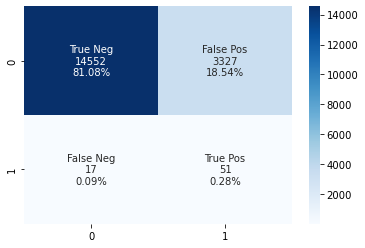

In [49]:
warnings.filterwarnings('ignore')
model_3 = LogisticRegression(random_state = random_state, solver = 'liblinear', 
                                                max_iter = 1000, class_weight = 'balanced',
                                                verbose = 0, n_jobs = -1, C = 1e+5)
model_3.fit(imp_col_50[0], target_train)
predictions_3 = model_3.predict(imp_col_50[1])
cf_matrix_result_3 = confusion_matrix(target_valid, predictions_3)
cf_matrix_graph(cf_matrix_result_3)

print('Accuracy 0: ', accuracy_0(target_valid, predictions_3))
print('Accuracy 1: ', accuracy_1(target_valid, predictions_3))
print('Precision: ', precision_score(target_valid, predictions_3))
print('Recall: ', recall_score(target_valid, predictions_3))
print('F1: ', f1_score(target_valid, predictions_3))
print('Accuracy: ', accuracy_score(target_valid, predictions_3))
print('ROC-AUC: ', roc_auc_score(target_valid, predictions_3))

Таким образом, наилучшей моделью является первая.

## 4. Тестирование модели

Протестируем наилучшую модель на тестовой выборке и получим метрики качества:

Accuracy 0:  0.8223514934556438
Accuracy 1:  0.7536231884057971
Precision:  0.0161090458488228
Recall:  0.7536231884057971
F1:  0.03154382772217167
Accuracy:  0.8220872569231626
ROC-AUC:  0.7879873409307205


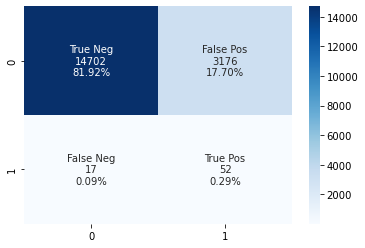

In [50]:
model_test = LogisticRegression(random_state = random_state, solver = 'liblinear', 
                                                max_iter = 1000, class_weight = 'balanced',
                                                verbose = 0, n_jobs = -1, C = 5e-3)
model_test.fit(features_train, target_train)
predictions_test = model_test.predict(features_test)
cf_matrix_result_test = confusion_matrix(target_test, predictions_test)
cf_matrix_graph(cf_matrix_result_test)

print('Accuracy 0: ', accuracy_0(target_test, predictions_test))
print('Accuracy 1: ', accuracy_1(target_test, predictions_test))
print('Precision: ', precision_score(target_test, predictions_test))
print('Recall: ', recall_score(target_test, predictions_test))
print('F1: ', f1_score(target_test, predictions_test))
print('Accuracy: ', accuracy_score(target_test, predictions_test))
print('ROC-AUC: ', roc_auc_score(target_test, predictions_test))

На тестовой выборке качество модели осталось таким же, как и на валидационной.

Таким образом, получена модель, верно предсказывающая клиентов, которым можно выдать заём - на 75.36%, которым нужно откзаать - на 82.24%.